In [1]:
import sys
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

atlas_path = "C:/Users/natha/OneDrive/Desktop/C++/Atlas/x64/Debug"
sys.path.append(atlas_path)


from AtlasPy.core import Hydra, Portfolio, Strategy
from AtlasPy.ast import *

In [2]:
exchange_path = "C:/Users/natha/OneDrive/Desktop/C++/Atlas/AtlasPy/src/exchangeVBT"
strategy_id = "test_strategy"
exchange_id = "test_exchange"
portfolio_id = "test_portfolio"

hydra = Hydra()
intial_cash = 100.0
exchange = hydra.addExchange(exchange_id, exchange_path, "")
portfolio = hydra.addPortfolio(portfolio_id, exchange, intial_cash)
hydra.build()

In [3]:
st = time.perf_counter_ns()
n = 2
close = AssetReadNode.make("Close", 0, exchange)
prev_close = AssetReadNode.make("Close", -1, exchange)
change = AssetOpNode.make(
    close,
    prev_close,
    AssetOpType.SUBTRACT
)

close_arg_max = exchange.registerObserver(TsArgMaxObserverNode("arg_max", change, n))
close_max = exchange.registerObserver(MaxObserverNode("max", change, n))
exchange.enableNodeCache("close_arg_max",close_arg_max, False)
exchange.enableNodeCache("close_max",close_max, False)

ev = ExchangeViewNode.make(exchange, close)
allocation = AllocationNode.make(
    ev
)
strategy_node_signal = StrategyNode.make(allocation, portfolio)
strategy = hydra.addStrategy(Strategy(strategy_id, strategy_node_signal, 1.0), True)
strategy.enableTracerHistory(TracerType.NLV)
hydra.run()
et = time.perf_counter_ns()
print("Time (ms): ", (et-st)/1e6)

Time (ms):  211.3171


In [4]:
ticker = "BTC-USD"
asset_id = exchange.getAssetIndex(ticker)
path = os.path.join(exchange_path,f"{ticker}.csv")  
df = pd.read_csv(path)
df["Date"] = pd.to_datetime(df["Date"]) 
df = df.set_index("Date")

def ts_argmax(df, window=10):
    """
    Wrapper function to estimate which day ts_max(df, window) occurred on
    :param df: a pandas DataFrame.
    :param window: the rolling window.
    :return: well.. that :)
    """
    return df.rolling(window).apply(np.argmax).add(1)

btc_idx = exchange.getAssetIndex("BTC-USD")
df["close_arg_max_atlas"] = close_arg_max.cache()[btc_idx].T
df["close_max_atlas"] = close_max.cache()[btc_idx].T
df["close_max_pd"] = df["Close"].diff().rolling(n).max()
df["close_arg_max_pd"] = ts_argmax(df["Close"].diff(), n)
df["change"] = df["Close"].diff()
df = df[["Close","change", "close_max_atlas", "close_max_pd", "close_arg_max_pd", "close_arg_max_atlas"]]
df.head(30)

,Close,change,close_max_atlas,close_max_pd,close_arg_max_pd,close_arg_max_atlas
Date,,,,,,
2018-01-01 00:00:00+00:00,13657.200195,NaN,0.000000,NaN,NaN,0.0
2018-01-02 00:00:00+00:00,14982.099609,1324.899414,1324.899414,NaN,NaN,0.0
2018-01-03 00:00:00+00:00,15201.000000,218.900391,1324.899414,NaN,NaN,0.0
2018-01-04 00:00:00+00:00,15599.200195,398.200195,1324.899414,NaN,NaN,0.0
2018-01-05 00:00:00+00:00,17429.500000,1830.299805,1830.299805,NaN,NaN,5.0
2018-01-06 00:00:00+00:00,17527.000000,97.500000,1830.299805,1830.299805,4.0,4.0
2018-01-07 00:00:00+00:00,16477.599609,-1049.400391,1830.299805,1830.299805,3.0,3.0
2018-01-08 00:00:00+00:00,15170.099609,-1307.500000,1830.299805,1830.299805,2.0,2.0
2018-01-09 00:00:00+00:00,14595.400391,-574.699219,1830.299805,1830.299805,1.0,1.0


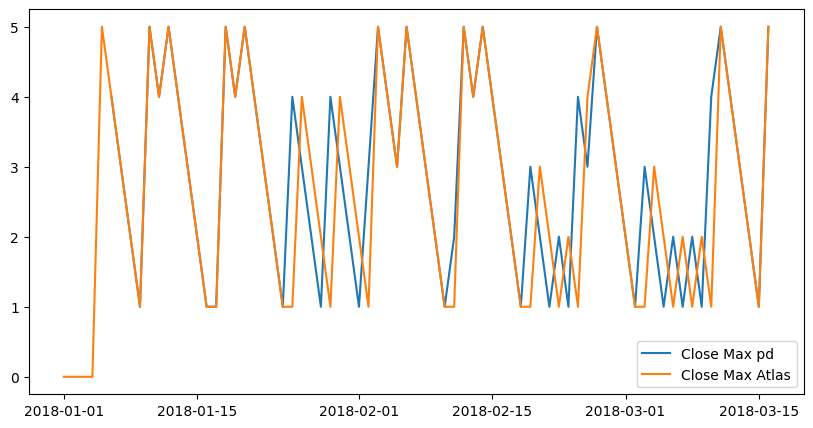

In [5]:
n = 75
df_sub = df.iloc[0:n]
fig= plt.figure(figsize=(10,5))
plt.plot(df_sub.index,df_sub["close_arg_max_pd"], label="Close Max pd")
plt.plot(df_sub.index,df_sub["close_arg_max_atlas"], label="Close Max Atlas")
plt.legend()

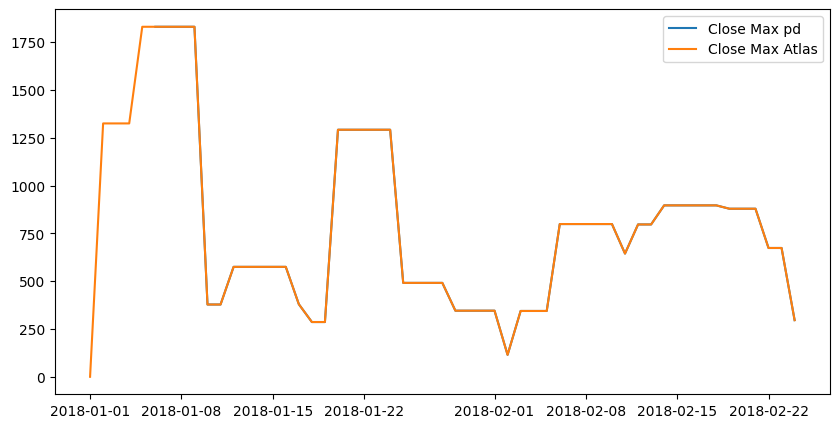

In [6]:
n = 55
df_sub = df.iloc[0:n]
fig= plt.figure(figsize=(10,5))
plt.plot(df_sub.index,df_sub["close_max_pd"], label="Close Max pd")
plt.plot(df_sub.index,df_sub["close_max_atlas"], label="Close Max Atlas")
plt.legend()

In [7]:
buffer = [-574,1830,97,-1049,-1307]
start_idx = 2
exclude_idx = 1
new_max_relative_idx = 2

buffer = [-574,377,97,-1049,-1307]
start_idx = 3
exclude_idx = 2
new_max_relative_idx = 1

In [8]:
def relative_index(idx, start_idx, length):
    rel_idx = (idx - start_idx) % length
    print(f"Relative index: {rel_idx}")
    return rel_idx

def max_idx(buffer, start_idx, exclude_idx):
    max_val = buffer[start_idx]
    max_idx = start_idx
    for i in range(len(buffer)):
        if i == exclude_idx:
            continue
        if buffer[i] > max_val:
            max_val = buffer[i]
            max_idx = i
    print(f"Max value: {max_val}, Max index: {max_idx}")
    return relative_index(max_idx, start_idx, len(buffer))


# Example usage:
buffer = [-574,1830,97,-1049,-1307]
start_idx = 2
exclude_idx = 1
new_max_relative_idx = 0
print(f"Max index: {max_idx(buffer, start_idx, exclude_idx)}")

Max value: 97, Max index: 2
Relative index: 0
Max index: 0


In [9]:
# Example usage:
buffer = [-574,377,97,-1049,-1307]
start_idx = 3
exclude_idx = 2
new_max_relative_idx = 1
print(f"Max index: {max_idx(buffer, start_idx, exclude_idx)}")

Max value: 377, Max index: 1
Relative index: 3
Max index: 3


In [10]:
(1-3+5)%5

3